Building the model described in Faizi et. al. 2018 "A model of optimal protein allocation during phototrophic growth" Biosystems, 166: 26-36.

In [11]:
import tellurium as te
import math
import numpy as np
import matplotlib.pyplot as plt
from tellurium import ParameterScan
from tellurium.analysis.parameterscan import plot2DParameterScan
te.getVersionInfo()

[('tellurium', '2.1.1'),
 ('roadrunner', '1.5.2'),
 ('antimony', '2.9.4'),
 ('libsbml', '5.15.0'),
 ('libsedml', '0.4.3'),
 ('phrasedml', '1.0.9')]

In [6]:
model Faizi

    const Ci_ext; # extracellular inorganic carbon
    var Ci_int; # intracellular inorganic carbon
    var Energy; # energy units (here representing the ATP, NADH, etc pool)
    var AminoAcid; # amino acids
    var Photoenzyme; # photosynthetic machinery
    var Transporter; # transporter protein for inorganic carbon
    var Metaenzyme; # metabolic multi-enzyme complex
    var Ribosome; # ribosome
    
    compartment Environment, Cell
    
    Environment = 1.0;
    Cell = 1.0;
    
    species Ci_ext, Ci_int, Energy, AminoAcid, Ribosome, Transporter, Metaenzyme, Photoenzyme;
    
    Ci_ext in Environment;
    Ci_int in Cell;
    Energy in Cell;
    AminoAcid in Cell;
    Ribosome in Cell; 
    Transporter in Cell; 
    Metaenzyme in Cell; 
    Photoenzyme in Cell; 
    
    // Initializing variables
    Energy = 1.0e4
    AminoAcid = 1.0e4
    Ribosome = 1.0e4
    Transporter = 1.0e4
    Metaenzyme = 1.0e4
    Photoenzyme = 1.0e4
    Ci_ext = 1000;
    Ci_int = 1000;
    
    // Setting proportions of protein translation rates (beta_i > 0; sum(beta_i)<=1)    
    beta_R = 0.2
    beta_T = 0.2
    beta_M = 0.2
    beta_P = 0.2
    
    // Geometric Constants
    Perm_membrane = 0.0018; # permeability, dm min-1
    area_cell = 3.85e-9; # cell surface area, dm2 cell-1
    volume_cell = 2.24e-14; # L, cell-1
    N_a = 6.022e23; # Avogadro constant, mol-1
    sec2min = 60;
    
    // Kinetic Constants
    kcat_T = 726; # maximal import rate, min-1
    Km_T = 15; # Menten constant of T, uM
    kcat_M = 545; # maximal metabolic rate, min-1
    Km_M = 2441560; # Menten constant of M, molecules cell-1
    gamma_max = 1320; # maximal translation rate, aa min-1 molecules-1
    Km_AA = 10000; # Menten constant for aa, molecule cell-1
    Km_E = 10000; # Menten constant for e, molecule cell-1
    abs_xsec = 0.166; # effective absorption cross-section of P, m2 uE-1
    turnover_P = 1900; # maximal turnover rate of P, min-1
    k_d = 1.6e-6; # rate constant for photodamage
    K_i = 1.0e8; # product-inhibition constant for e synthesis, molecule cell-1
    
    // Material Constants
    Dens_C = 1.4e10; # average cell density, aa cell-1
    n_R = 7358; # ribosome length, aa molecule-1
    n_T = 1681; # transporter length, aa molecule-1
    n_M = 28630; # metabolic enzyme complex length, aa molecule-1
    n_P = 95451; # photosynthetic unit length, aa molecule-1
    m_mu = 45; # e needed to create one aa
    m_gamma = 3; # e needed for one translational elongation step
    m_phi = 8; # e produced by P cycle
    m_c = 5; # average carbon chain length of aa
    Irradiance = 1000; # uE per second
    
    // Assignment Rules
    v_t := Transporter * kcat_T * (Ci_ext/(Km_T+Ci_ext)) * (Energy/(Km_E+Energy));
    
    v_m := Metaenzyme * kcat_M * (Ci_int/(Km_M+Ci_int)) * (Energy/(Km_E+Energy));
    
    gamma_R := beta_R * (gamma_max / n_R) * Ribosome * (Energy/(Km_E+Energy)) * (AminoAcid/(Km_AA+AminoAcid));
    
    gamma_T := beta_T * (gamma_max / n_T) * Ribosome * (Energy/(Km_E+Energy)) * (AminoAcid/(Km_AA+AminoAcid));
    
    gamma_M := beta_M * (gamma_max / n_M) * Ribosome * (Energy/(Km_E+Energy)) * (AminoAcid/(Km_AA+AminoAcid));
    
    gamma_P := beta_P * (gamma_max / n_P) * Ribosome * (Energy/(Km_E+Energy)) * (AminoAcid/(Km_AA+AminoAcid));
    
    k2e := turnover_P / (1+(Energy/K_i)^4);
    
    v2 := (k2e*abs_xsec*Irradiance*sec2min*Photoenzyme)/(abs_xsec*Irradiance*sec2min+k2e+mu);
    
    translation := (n_R*gamma_R + n_T*gamma_T + n_M*gamma_M + n_P*gamma_P);
    
    mu := (1/Dens_C) * (v_t/m_c);
    
    // Rates Laws
    
    AA_P: -> AminoAcid; v_m;
    AA_C: AminoAcid -> ; translation + mu*AminoAcid;
    
    CI_P: -> Ci_int; v_t;
    CI_C: Ci_int -> ; v_m*m_c + mu*Ci_int;
    
    M_P: -> Metaenzyme; gamma_M;
    M_C: Metaenzyme ->; mu*Metaenzyme;
    
    T_P: -> Transporter; gamma_T;
    T_C: Transporter -> ; mu*Transporter;
    
    R_P: -> Ribosome; gamma_R;
    R_C: Ribosome -> ; mu*Ribosome;
    
    P_P: -> Photoenzyme; gamma_P;
    P_C: Photoenzyme -> ; mu*Photoenzyme;
    
    E_P: -> Energy; m_phi*v2;
    E_C: Energy -> ; v_t+v_m*m_mu + mu*Energy + m_gamma*translation;
    
    
end

Success: Model can be accessed via variable Faizi


In [6]:
Faizi.reset()
results = Faizi.simulate(start = 0, end = 1e5, steps = 1000,selections =['time','mu'])
Faizi.plot()

Faizi.steadyStateSelections = ['Ci_int','Energy','AminoAcid','mu']
values = Faizi.getSteadyStateValues()
selections = Faizi.steadyStateSelections
print(values)
print(selections)

In [21]:
results = Faizi.simulate(start = 0, end = 1e5, steps = 1000,selections =['time','mu','Ci_int','Energy','AminoAcid'])

plt.figure(figsize=(30,10));
plt.rc('font', size=30);

plt.subplot(2,2,1);
plt.plot(results['time'], results['Ci_int']);
plt.legend({'Ci_int'});

plt.subplot(2,2,2);
plt.plot(results['time'], results['AminoAcid']);
plt.legend({'AminoAcid'});

plt.subplot(2,2,3);
plt.plot(results['time'],results['Energy']);
plt.legend({'Energy'});

plt.subplot(2,2,4);
plt.plot(results['time'],results['mu']);
plt.legend({'Growth rate'});

In [22]:
plot2DParameterScan(Faizi,
                    p1='Irradiance',p1Range=np.linspace(0,1000,num=5),
                   p2='Ci_ext',p2Range=np.linspace(0,1000,num=5),
                   start=20000, end = 100000, points = 11)


In [12]:
p = te.SteadyStateScan(Faizi,
    value = 'Irradiance',
    startValue = 0,
    endValue = 1000,
    numberOfPoints = 20,
    selection = ['mu']
)


p.plotArray()

te.plotArray(p,ylabel="Growth Rate")


In [10]:
p1 = te.SteadyStateScan(Faizi,
    value = 'Irradiance',
    startValue = 0,
    endValue = 1000,
    numberOfPoints = 20,
    selection = ['Energy']
)
p1.plotArray()

In [9]:
Faizi.reset()
Faizi.Ci_ext = 10;
for i in range (1,11):
  numbers = np.linspace (0, 1000, 10)
  result = np.empty ([0,2])
  for value in numbers:
      Faizi.Irradiance = value
      Faizi.steadyState()
      row = np.array ([value, Faizi.AminoAcid])
      result = np.vstack ((result, row))
  te.plotArray(result, show=False, labels=['Ci_ext={}'.format(Faizi.Ci_ext)],
               resetColorCycle=False,
               xlabel='Irradiance', ylabel="AminoAcid",
               title="Steady State Amino Acid concentration with Irradiance and External inorganic carbon"
               )
  Faizi.Ci_ext = Faizi.Ci_ext + 100;

In [4]:
Faizi.reset()
Faizi.Ci_ext = 10;
for i in range (1,11):
  numbers = np.linspace (0, 1000, 10)
  result = np.empty ([0,2])
  for value in numbers:
      Faizi.Irradiance = value
      Faizi.steadyState()
      row = np.array ([value, Faizi.Energy])
      result = np.vstack ((result, row))
  te.plotArray(result, show=False, labels=['Ci_ext={}'.format(Faizi.Ci_ext)],
               resetColorCycle=False,
               xlabel='Irradiance', ylabel="Energy",
               title="Steady State S2 for different Km1 & Km2"
               )
  Faizi.Irradiance = 0.1
  Faizi.Ci_ext = Faizi.Ci_ext + 100;

In [7]:
Faizi.reset()
Faizi.Ci_ext = 50;
for i in range (1,3):
  numbers = np.linspace (0, 1000, 10)
  result = np.empty ([0,2])
  for value in numbers:
      Faizi.Irradiance = value
      Faizi.steadyState()
      row = np.array ([value, Faizi.mu*60])
      result = np.vstack ((result, row))
  te.plotArray(result, show=False, labels=['Ci_ext={}'.format(Faizi.Ci_ext)],
               resetColorCycle=False,
               xlabel='Irradiance', ylabel="Growth rate",
               title="Steady State S2 for different Km1 & Km2"
               )
  Faizi.Ci_ext = Faizi.Ci_ext + 950;

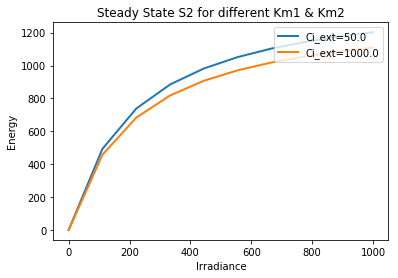

In [7]:
Faizi.reset()
Faizi.Ci_ext = 50;
for i in range (1,3):
  numbers = np.linspace (0, 1000, 10)
  result = np.empty ([0,2])
  for value in numbers:
      Faizi.Irradiance = value
      Faizi.steadyState()
      row = np.array ([value, Faizi.Energy])
      result = np.vstack ((result, row))
  te.plotArray(result, show=False, labels=['Ci_ext={}'.format(Faizi.Ci_ext)],
               resetColorCycle=False,
               xlabel='Irradiance', ylabel="Energy",
               title="Steady State S2 for different Km1 & Km2"
               )
  Faizi.Ci_ext = Faizi.Ci_ext + 950;